In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import *
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import astropy
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import constants as const
import hdbscan
from astropy.io import fits
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm.notebook import tqdm

In [2]:
GrID = pd.read_csv('rcsed_iGrID.csv')
NANfilter = pd.notna(GrID.iGrID)
y = GrID[NANfilter]
hdul = fits.open('rcsed_v2_clean.fits', memmap=astropy.io.fits.Conf.use_memmap.defaultvalue, lazy_load_hdus=True)
data = hdul[1].data
hdul.close()
DATA = pd.DataFrame(np.array(data).byteswap().newbyteorder())
del data

In [3]:
DATA.drop('ind', axis=1, inplace=True)
display(DATA.head())

,ra,dec,z_sdss,zerr_sdss,specObjID_sdss,bestObjID_sdss,plate_sdss,mjd_sdss,fiberID_sdss,z_2df,...,expRadErr_g,expAB_g,expABErr_g,expPhi_g,expMag_g,expFlux_g,expFluxIvar_g,expMagErr_g,modelMag_g,modelMagErr_g
0,0.000019,-4.760800,2.467120,0.002194,7.919679e+18,0,7034,56564,360,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000091,24.902252,0.555936,0.000245,7.333218e+18,1237666309095751941,6513,56543,843,NaN,...,11.760200,0.249997,0.369362,83.70193,22.08381,1.461627,1.991625,0.522415,23.18259,0.386604
2,0.000346,-6.491940,0.514177,0.000130,8.047035e+18,1237680243597902184,7147,56574,831,NaN,...,1.559838,0.147778,0.201906,84.34074,21.86258,1.794235,11.132140,0.180460,21.12392,0.183285
3,0.000463,10.241074,0.654380,0.000170,6.960408e+18,1237679319089349467,6182,56190,346,NaN,...,2.020618,0.265576,0.520042,43.52781,22.94896,0.649079,20.061290,0.359881,23.39049,0.270960
4,0.000559,34.985602,0.146326,0.000021,8.044630e+18,1237666184574271705,7145,56567,274,NaN,...,0.037337,0.722592,0.026249,126.50180,18.75811,31.387160,12.734440,0.009693,18.37597,0.009515


In [4]:
DATA.shape

(4105516, 558)

In [5]:
DATA = DATA.select_dtypes(include='number')
DATA.shape

(4105516, 552)

In [6]:
DATA.replace([-2147483648, -9223372036854775808,-32768,255, -999999488.0,
 99.0,
 0.0,
 -99.0,
 9999.0,
 -999.0,
 0.05299999937415123,
 float('inf'),
 3.5,
 -9999.0,
 4.619999885559082,
 0.05000000074505806,
 70.0,
 4.0,
 179.96949768066406,
 0.06128999963402748,
 24.6346492767334], np.nan, inplace=True)

In [7]:
DATA.dropna(axis=1,
    how='all',
    thresh=None,
    subset=None,
    inplace=True)
DATA.shape

(4105516, 548)

In [9]:
top_values = []

for col in DATA.columns[1:]:
    vc = DATA[col].value_counts(ascending=False).head(1)
    top_values.append([vc.name, vc.index[0], vc[vc.index[0]]])
    
anomaly = pd.DataFrame(data=top_values, columns = ['column_name', 'anomaly_value', 'value_counts'])

In [10]:
not_nan = []

for col in DATA.columns[1:]:
    not_nan.append((~DATA[col].isna()).sum())
    
not_nan = pd.Series(not_nan)

In [11]:
import copy

top_values_data = copy.copy(anomaly)

top_values_data['percent_total'] = (top_values_data.value_counts / len(DATA)).round(3)
top_values_data['percent_not_nan'] = (top_values_data.value_counts / not_nan).round(3)
top_values_data['non_null_part'] = (not_nan / len(DATA)).round(3)

In [12]:
columns_drop = top_values_data[(top_values_data['percent_not_nan'] > 0.9) | (top_values_data['non_null_part'] < 0.1)].column_name 

In [13]:
DATA.shape

(4105516, 548)

In [14]:
DATA.drop(labels=columns_drop, axis = 1, inplace=True)

In [15]:
DATA.shape

(4105516, 348)

In [16]:
nrmlzr = MinMaxScaler()
x = nrmlzr.fit_transform(DATA)
del DATA

In [17]:
#x = x[NANfilter]

In [18]:
'''from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

imputer = IterativeImputer(max_iter=10, tol=3*x.std().max(),random_state=42, 
                           estimator=DecisionTreeRegressor(max_features='sqrt'))

for i in tqdm(range(10)):
    fit_x = x[np.random.choice(len(x), 10000)]
    imputer.fit(fit_x)
x = imputer.transform(x)'''

"from sklearn.experimental import enable_iterative_imputer\nfrom sklearn.impute import IterativeImputer\n\nfrom sklearn.ensemble import ExtraTreesRegressor\nfrom sklearn.tree import DecisionTreeRegressor\nfrom sklearn.neighbors import KNeighborsRegressor\n\nimputer = IterativeImputer(max_iter=10, tol=3*x.std().max(),random_state=42, \n                           estimator=DecisionTreeRegressor(max_features='sqrt'))\n\nfor i in tqdm(range(10)):\n    fit_x = x[np.random.choice(len(x), 10000)]\n    imputer.fit(fit_x)\nx = imputer.transform(x)"

In [17]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
x = imputer.fit_transform(x)

In [18]:
class VAE(nn.Module):
    def __init__(self, x_dim, z_dim):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(x_dim, x_dim//2)
        self.fc2 = nn.Linear(x_dim//2, x_dim//4)
        self.fc3 = nn.Linear(x_dim//4, x_dim//8)
        self.fc41 = nn.Linear(x_dim//8, z_dim)
        self.fc42 = nn.Linear(x_dim//8, z_dim)

        self.fc5 = nn.Linear(z_dim, x_dim//8)
        self.fc6 = nn.Linear(x_dim//8, x_dim//4)
        self.fc7 = nn.Linear(x_dim//4, x_dim//2)
        self.fc8 = nn.Linear(x_dim//2, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.fc41(h), self.fc42(h)
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
        
    def decoder(self, z):
        h = F.relu(self.fc5(z))
        h = F.relu(self.fc6(h))
        h = F.relu(self.fc7(h))
        return torch.sigmoid(self.fc8(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, x.shape[1]))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [47]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vae = VAE(x_dim=x.shape[1], z_dim=5).to(device)

optimizer = optim.Adam(vae.parameters())

data_loader = torch.utils.data.DataLoader(x.astype(np.float32), batch_size=5000, shuffle=True)
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, x.shape[1]), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, data in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        '''if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), x.shape[0],
                100. * batch_idx / 1000, loss.item() / len(data)))'''
    print('====> Epoch: {} Average loss: {:.8f}'.format(epoch, train_loss / x.shape[0]))
    

In [ ]:
for epoch in tqdm(range(1, 51)):
    train(epoch)

====> Epoch: 1 Average loss: 125.87517464
====> Epoch: 2 Average loss: 122.95665429
====> Epoch: 3 Average loss: 122.90931981
====> Epoch: 4 Average loss: 122.90250255
====> Epoch: 5 Average loss: 122.89792189
====> Epoch: 6 Average loss: 122.89492919
====> Epoch: 7 Average loss: 122.89257729
====> Epoch: 8 Average loss: 122.89188482
====> Epoch: 9 Average loss: 122.88948106
====> Epoch: 10 Average loss: 122.88859826
====> Epoch: 11 Average loss: 122.88667965
====> Epoch: 12 Average loss: 122.88493482
====> Epoch: 13 Average loss: 122.88436583
====> Epoch: 14 Average loss: 122.88325607
====> Epoch: 15 Average loss: 122.88296800
====> Epoch: 16 Average loss: 122.88228233
====> Epoch: 17 Average loss: 122.88223943
====> Epoch: 18 Average loss: 122.88203444
====> Epoch: 19 Average loss: 122.88169127
====> Epoch: 20 Average loss: 122.88212750
====> Epoch: 21 Average loss: 122.88165932
====> Epoch: 22 Average loss: 122.88181402
====> Epoch: 23 Average loss: 122.88086791
====> Epoch: 24 Aver

In [59]:
mu, log_var = vae.encoder(torch.tensor(x.astype(np.float32)))
embed = vae.sampling(mu, log_var).detach().numpy()

**Iterative Imputer, z=5**

In [24]:
#hdbScan = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, allow_single_cluster=True).fit(embed)

In [25]:
#homogeneity_completeness_v_measure(y.iGrID, hdbScan.labels_)

In [26]:
#hdbScan = hdbscan.HDBSCAN(min_cluster_size=9, min_samples=2, allow_single_cluster=True).fit(embed)

In [27]:
#homogeneity_completeness_v_measure(y.iGrID, hdbScan.labels_)

In [28]:
#hdbScan = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=2, allow_single_cluster=True).fit(embed)

In [29]:
#homogeneity_completeness_v_measure(y.iGrID, hdbScan.labels_)

In [30]:
#hdbScan = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, allow_single_cluster=True).fit(embed)

In [31]:
#homogeneity_completeness_v_measure(y.iGrID, hdbScan.labels_)

In [32]:
#np.unique(hdbScan.probabilities_)

**Simple Imputer, z=3. VAE 20 E**

In [33]:
hdbScan = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, allow_single_cluster=True).fit(embed)

In [34]:
homogeneity_completeness_v_measure(y.iGrID, hdbScan.labels_)

(0.7778098682302218, 0.9014110352007361, 0.835061542026093)

**Simple Imputer, z=2, VAE 20 E**

In [38]:
hdbScan = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, allow_single_cluster=True).fit(embed)

In [39]:
homogeneity_completeness_v_measure(y.iGrID, hdbScan.labels_)

(0.813767260257694, 0.9032521804769117, 0.8561779031622472)

**Simple Imputer, z=1, VAE 20 E**

In [43]:
hdbScan = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, allow_single_cluster=True).fit(embed)

In [44]:
homogeneity_completeness_v_measure(y.iGrID, hdbScan.labels_)

(0.8585356649593051, 0.905938883908761, 0.8816005224989566)

**Simple Imputer, z=1, VAE 100 E**

In [50]:
hdbScan = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, allow_single_cluster=True).fit(embed)

In [51]:
homogeneity_completeness_v_measure(y.iGrID, hdbScan.labels_)

(0.8580607246286622, 0.9059051391109436, 0.8813340848472478)

**Simple Imputer, z=1, VAE 20 E, Batch 10000**

In [55]:
hdbScan = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, allow_single_cluster=True).fit(embed)

In [56]:
homogeneity_completeness_v_measure(y.iGrID, hdbScan.labels_)

(0.8576638176053267, 0.9058942186629216, 0.8811195072083883)

**Simple Imputer, z=1, VAE 100 E, Batch 10000**

In [60]:
hdbScan = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, allow_single_cluster=True).fit(embed)

In [61]:
homogeneity_completeness_v_measure(y.iGrID, hdbScan.labels_)

(0.8581847834479922, 0.9059279747981961, 0.88141032849236)

In [65]:
zs_res = []
for z in [1, 2, 3, 4, 5, 10, 15]:
    vae = VAE(x_dim=x.shape[1], z_dim=z)
    for e in range(20):
        train(e)
    mu, log_var = vae.encoder(torch.tensor(x.astype(np.float32)))
    embed = vae.sampling(mu, log_var).detach().numpy()
    hdbScan = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, allow_single_cluster=True).fit(embed)
    zs_res.append(homogeneity_completeness_v_measure(y.iGrID, hdbScan.labels_))

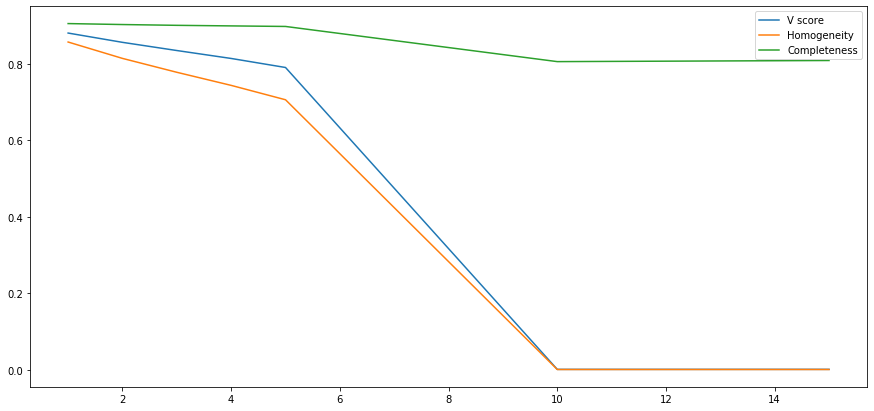

In [75]:
plt.figure(figsize=(15,7))
plt.plot([1, 2, 3, 4, 5, 10, 15], [r[2] for r in zs_res], label='V score')
plt.plot([1, 2, 3, 4, 5, 10, 15], [r[0] for r in zs_res], label='Homogeneity')
plt.plot([1, 2, 3, 4, 5, 10, 15], [r[1] for r in zs_res], label='Completeness')
plt.legend()
plt.show()